# Lab 3 - Boosting
## Nick Bias
### 4/17/22
### Libraries 

In [2]:
import pandas as pd
import numpy as np

# For Boosting 
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# For Comparision Models
# compare standalone models for binary classification
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# For splitting data into training and testing 
from sklearn.model_selection import train_test_split
# example of calculate the mean absolute error
from sklearn.metrics import accuracy_score

# For Evaluations 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# So results are same when re-run
import random
random.seed(10)

## Goal: Predict Heart Disease
### Importing Dataset

In [3]:
heart = pd.read_csv("Data/Week4/heart_2020_cleaned.csv")
heart

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


As we can see there are a lot of string values. These will most likely need to be changed into Dummy variables with 1s and 0s for easier analysis. 

### Data Cleaning

In [4]:
# Converts Columns with binary answers to 1s and 0s 
heart['HeartDisease'] = heart['HeartDisease'].eq('Yes').mul(1)
heart['Smoking'] = heart['Smoking'].eq('Yes').mul(1)
heart['AlcoholDrinking'] = heart['AlcoholDrinking'].eq('Yes').mul(1)
heart['Stroke'] = heart['Stroke'].eq('Yes').mul(1)
heart['DiffWalking'] = heart['DiffWalking'].eq('Yes').mul(1)
heart['Sex'] = heart['Sex'].eq('Male').mul(1)
heart['Diabetic'] = heart['Diabetic'].eq('Yes').mul(1)
heart['PhysicalActivity'] = heart['PhysicalActivity'].eq('Yes').mul(1)
heart['Asthma'] = heart['Asthma'].eq('Yes').mul(1)
heart['KidneyDisease'] = heart['KidneyDisease'].eq('Yes').mul(1)
heart['SkinCancer'] = heart['SkinCancer'].eq('Yes').mul(1)

# created Dummy Variables for Columns with more than 1 category
age = pd.get_dummies(heart['AgeCategory'])
race = pd.get_dummies(heart['Race'])
genhealth = pd.get_dummies(heart['GenHealth'])

# Merges Datasets together 
heart = pd.merge(heart, age, left_index=True, right_index=True)
heart = pd.merge(heart, race, left_index=True, right_index=True)
heart = pd.merge(heart, genhealth, left_index=True, right_index=True)

# Drops Columns with Dummy variables 
heart = heart.drop(['AgeCategory', 'Race', 'GenHealth'], axis = 1)

heart


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,...,Asian,Black,Hispanic,Other,White,Excellent,Fair,Good,Poor,Very good
0,0,16.60,1,0,0,3.0,30.0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,26.58,1,0,0,20.0,30.0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,23.71,0,0,0,28.0,0.0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,1,1,...,0,0,1,0,0,0,1,0,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
319792,0,24.24,0,0,0,0.0,0.0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [5]:
heart.dtypes

HeartDisease                        int32
BMI                               float64
Smoking                             int32
AlcoholDrinking                     int32
Stroke                              int32
PhysicalHealth                    float64
MentalHealth                      float64
DiffWalking                         int32
Sex                                 int32
Diabetic                            int32
PhysicalActivity                    int32
SleepTime                         float64
Asthma                              int32
KidneyDisease                       int32
SkinCancer                          int32
18-24                               uint8
25-29                               uint8
30-34                               uint8
35-39                               uint8
40-44                               uint8
45-49                               uint8
50-54                               uint8
55-59                               uint8
60-64                             

### Splitting Prediction Variable from dataset
- X = Dataset with all Independent Variables 
- y = The Dependent Variable of Heart Disease

In [4]:
y = heart["HeartDisease"]
X = heart.drop("HeartDisease", axis=1)

In [5]:
df = heart['HeartDisease'].value_counts().reset_index()
df.columns = ['col', 'count']
print (df)

   col   count
0    0  292422
1    1   27373


As we can see Heart Disease only makes up about 12% of the data. This is very unbalanced and will make prediction harder. 

## Baseline Models to Compare with 

Since the Target class is extremely unbalanced, We will be looking at the Precision, (proportion of positive identifications that are actually correct) and Recall (proportion of actual positives that were identified correctly). 

In [6]:
# This creates a Function that will Evalutate the models, by looking at Accuracy, Recall, Precision and ROC Curve
# This will be helpful in seeing how well the target class is being predicted 
def model_eval(model, X_test, y_test):
    assert len(X_test) == len(y_test), "X_test and y_test are not equal in size."
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[::, 1]
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_pred, y_test))
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'AUC: {round(auc, 3)}')
    plt.legend()
    plt.show()

In [7]:
# Splitting data into training and testing set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Previous Models

C:\Users\nbias\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[57897   534]
 [ 4926   602]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     62823
           1       0.11      0.53      0.18      1136

    accuracy                           0.91     63959
   macro avg       0.55      0.73      0.57     63959
weighted avg       0.98      0.91      0.94     63959



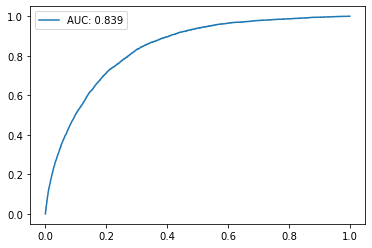

In [8]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
model_eval(log_model, X_test, y_test)

 The Logistic Regression Model has very high recall and precision for No Heart Disease, however, the recall and precision for Heart Disease classification are vvery low, meaning it is not accurately predicting the diseases. 

[[53971  4460]
 [ 4194  1334]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     58165
           1       0.24      0.23      0.24      5794

    accuracy                           0.86     63959
   macro avg       0.58      0.58      0.58     63959
weighted avg       0.86      0.86      0.86     63959



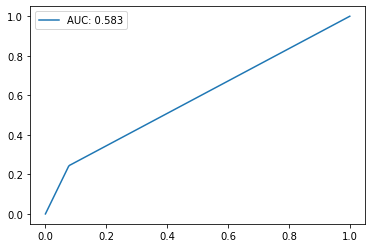

In [9]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
model_eval(model, X_test, y_test)

The Desicion Tree has much better recall and precision for Heart Disease classification, however these are still low. We can see that there will be a trade off for increasing recall and precision for Heart Disease classification, because recall and precision for No Heart Disease will decrease.

[[57043  1388]
 [ 4860   668]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     61903
           1       0.12      0.32      0.18      2056

    accuracy                           0.90     63959
   macro avg       0.55      0.62      0.56     63959
weighted avg       0.95      0.90      0.92     63959



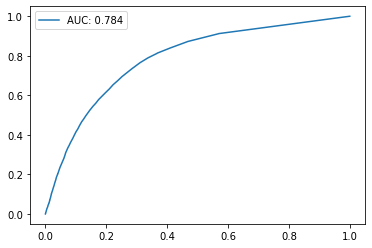

In [10]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
model_eval(model, X_test, y_test)

The Random Forest model has a higher recall than precision. Infact it is the highest recall out of the Previous Models. This is good but these are still low numbers. 

[[41316 17115]
 [ 1167  4361]]
              precision    recall  f1-score   support

           0       0.71      0.97      0.82     42483
           1       0.79      0.20      0.32     21476

    accuracy                           0.71     63959
   macro avg       0.75      0.59      0.57     63959
weighted avg       0.73      0.71      0.65     63959



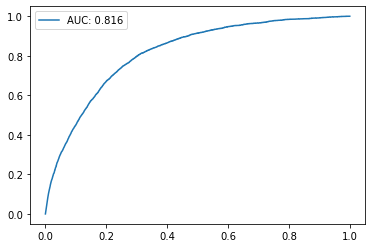

In [11]:
model = GaussianNB()
model.fit(X_train, y_train)
model_eval(model, X_test, y_test)

The Naive Bayes Model achieved the highest precision out of the Previous Models. This result is good, we just need to work with it more.

### Boosted Models 

[[57835   596]
 [ 4883   645]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     62718
           1       0.12      0.52      0.19      1241

    accuracy                           0.91     63959
   macro avg       0.55      0.72      0.57     63959
weighted avg       0.97      0.91      0.94     63959



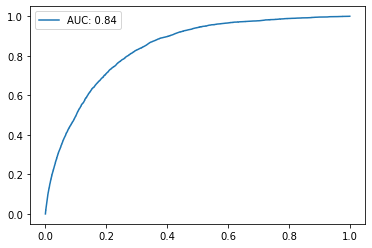

In [12]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
model_eval(model, X_test, y_test)

[[57989   442]
 [ 4989   539]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     62978
           1       0.10      0.55      0.17       981

    accuracy                           0.92     63959
   macro avg       0.54      0.74      0.56     63959
weighted avg       0.98      0.92      0.94     63959



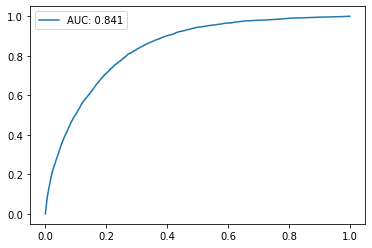

In [13]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
model_eval(model, X_test, y_test)

[[57946   485]
 [ 4986   542]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     62932
           1       0.10      0.53      0.17      1027

    accuracy                           0.91     63959
   macro avg       0.54      0.72      0.56     63959
weighted avg       0.98      0.91      0.94     63959



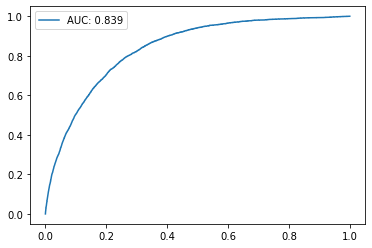

In [14]:
model = XGBClassifier()
model.fit(X_train, y_train)
model_eval(model, X_test, y_test)

All of the Boosted Models achieved around the same results. Accuracy was about 91% while Heart Disease precision was about 10%. This means that only 10% of positive identifications for Heart Disease are actually correct. Recall was about 53%, which means that only 53% OF actual positive Heart Disease was identified correctly. The recall is very good, but presicion needs to be boosted if these models will be able to accurately predict Heart Disease.

## Undersampling 
This is a technique used to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class.

In [15]:
undersample = RandomUnderSampler(sampling_strategy="majority")
X_over, y_over = undersample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2)

### AdaBoost

[[4099 1429]
 [1157 4265]]
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      5256
           1       0.79      0.75      0.77      5694

    accuracy                           0.76     10950
   macro avg       0.76      0.76      0.76     10950
weighted avg       0.76      0.76      0.76     10950



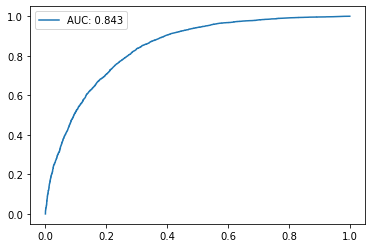

In [16]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
model_eval(model, X_test, y_test)

We can see that right have Undersampling the Precision and Recall for Heart Disease has gone up by over 30%. This is a great increase and means that Heart Disease is being classified more correctly. However, precision and recall went down by about 15% for Not Heart Disease.

[[4113 1415]
 [1175 4247]]
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      5288
           1       0.78      0.75      0.77      5662

    accuracy                           0.76     10950
   macro avg       0.76      0.76      0.76     10950
weighted avg       0.76      0.76      0.76     10950



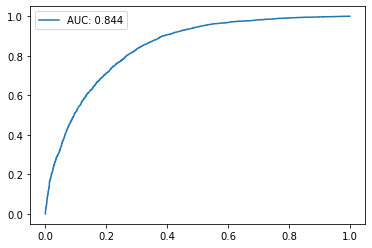

In [22]:
model = AdaBoostClassifier(n_estimators=500,
                           learning_rate=1, 
                           algorithm='SAMME')
model.fit(X_train, y_train)
model_eval(model, X_test, y_test)

Tuning the model has made its performance slightly worse. Because of this the base model will be used instead.

### Gradient Boost

[[4048 1480]
 [1085 4337]]
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      5133
           1       0.80      0.75      0.77      5817

    accuracy                           0.77     10950
   macro avg       0.77      0.77      0.77     10950
weighted avg       0.77      0.77      0.77     10950



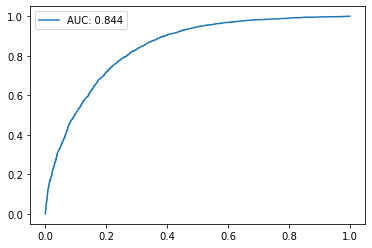

In [35]:
model_us1 = GradientBoostingClassifier()
model_us1.fit(X_train, y_train)
model_eval(model_us1, X_test, y_test)

the Gradient Boosted Model has very high Precision and Recall for Heart Disease and decent precision and recall for not Heart Disease.

[[4038 1490]
 [1116 4306]]
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      5154
           1       0.79      0.74      0.77      5796

    accuracy                           0.76     10950
   macro avg       0.76      0.76      0.76     10950
weighted avg       0.76      0.76      0.76     10950



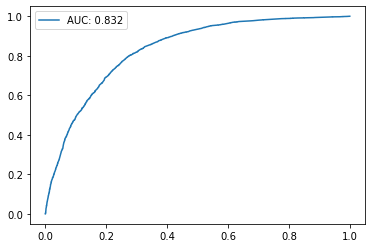

In [23]:
model_us = GradientBoostingClassifier(n_estimators=100, 
                                    learning_rate=1, 
                                    subsample=1, 
                                    max_depth=10, 
                                    min_impurity_decrease=1, 
                                    random_state=0)
model_us.fit(X_train, y_train)
model_eval(model_us, X_test, y_test)

Tunning parameters for this model does not seem to boost performance at all.

### XG Boost

[[3980 1548]
 [1065 4357]]
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      5045
           1       0.80      0.74      0.77      5905

    accuracy                           0.76     10950
   macro avg       0.76      0.76      0.76     10950
weighted avg       0.77      0.76      0.76     10950



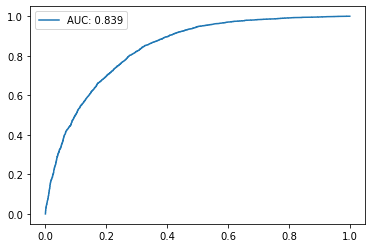

In [24]:
model = XGBClassifier()
model.fit(X_train, y_train)
model_eval(model, X_test, y_test)

[13:07:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[[4714  814]
 [3505 1917]]
              precision    recall  f1-score   support

           0       0.85      0.57      0.69      8219
           1       0.35      0.70      0.47      2731

    accuracy                           0.61     10950
   macro avg       0.60      0.64      0.58     10950
weighted avg       0.73      0.61      0.63     10950



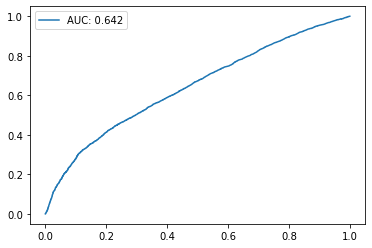

In [30]:
model = XGBClassifier(booster = 'gblinear', 
                      n_estimators=300, 
                       learning_rate = 1, 
                       gamma = 0.1, 
                       max_depth = 10, 
                       min_child_weight = 10,
                       max_delta_step = 10, 
                       subsample = 10,
                       reg_lambda = 1,
                       alpha = 0.1)
model.fit(X_train, y_train)
model_eval(model, X_test, y_test)

Once again, tunning the model seems to decrease its performance. 

Out of all the boosted models, **Gradient Boosting** appears to have done the best, but only slightly. For Heart Disease, its Precision is 80% of positive identifications were actually correct. And its recall is 75% of actual positives were identified correctly. This is much better than the models before Undersampling. The Precision and Recall for Not Heart Disease went down to 73% and 79% respectively. These are not bad results. The overall Accuracy of the model is 77%. As this is a massive unbalanced dataset and we are trying to predict a very difficult conditon to identify, these are very good results. 

## Feature Importance

In [44]:
heart.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'Diabetic',
       'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', '18-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older',
       'American Indian/Alaskan Native', 'Asian', 'Black', 'Hispanic', 'Other',
       'White', 'Excellent', 'Fair', 'Good', 'Poor', 'Very good'],
      dtype='object')

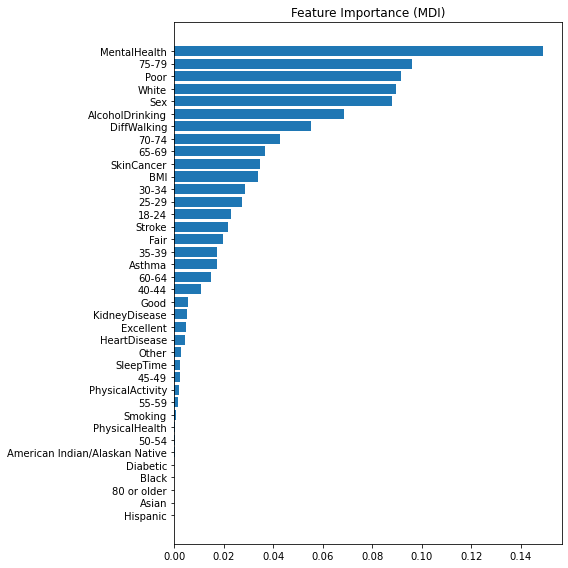

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
#
# Get Feature importance data using feature_importances_ attribute
#
feature_importance = model_us1.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')

plt.yticks(pos, np.array(heart.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
result = permutation_importance(model_us1, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

As we can see this is the breakdown of feature impoirtance in the Gradient Boost Model. 
People more likely to get Heart Disease are 
- Low MentalHealth
- Older people between 75-79
- Poor General Health
- White 
- Males 
- Alcohol Drinkers 

## Bag it, Stack it, and Boost it

This Produces a lot of Warnings

In [31]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', BaggingClassifier(base_estimator=LogisticRegression())))
    level0.append(('cart', BaggingClassifier(base_estimator=DecisionTreeClassifier())))
    level0.append(('forest', BaggingClassifier(base_estimator=RandomForestClassifier())))
    level0.append(('bayes', BaggingClassifier(base_estimator=GaussianNB())))
    level0.append(('adaboost', BaggingClassifier(base_estimator=AdaBoostClassifier())))
    level0.append(('gradboost', BaggingClassifier(base_estimator=GradientBoostingClassifier())))
    level0.append(('xgboost', BaggingClassifier(base_estimator=XGBClassifier())))
    # define meta learner model
    level1 = DecisionTreeClassifier()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, passthrough = True)
    return model
# passthrough is used for the stacking to take the og dataset instead of just the other model results

# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['cart'] = DecisionTreeClassifier()
    models['forest'] = RandomForestClassifier()
    models['bayes'] = GaussianNB()
    models['adaboost'] = AdaBoostClassifier()
    models['gradboost'] = GradientBoostingClassifier()
    models['xgboost'] = XGBClassifier()
    models['stacking'] = get_stacking()
    return models

# get the models to evaluate
models = get_models()

C:\Users\nbias\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nbias\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\nbias\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nbias\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\nbias\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nbias\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\nbias\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nbias\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[[3801 1727]
 [1770 3652]]
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      5571
           1       0.67      0.68      0.68      5379

    accuracy                           0.68     10950
   macro avg       0.68      0.68      0.68     10950
weighted avg       0.68      0.68      0.68     10950



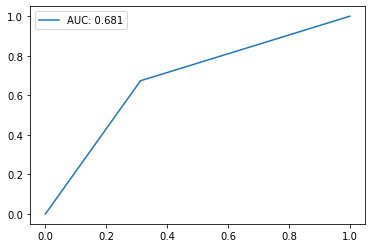

In [33]:
# Fitting model(s) to Training Data
models['stacking'].fit(X_train,y_train)
model_eval(models['stacking'], X_test, y_test)

This took a very long time to run, but it appears that bagging, stacking and boosting did not increase the model performance.